# Классификатор

Первоначально данный проект создавался группой где-то из 10 человек с нашего потока, у каждого свой стиль написания и скиллы, поэтому он получился немного неоднозначным и в некоторых местах спорным.  
Почему весь код был в формате .ipynb - загадка, видимо, кто-то начал и все стали делать по аналогии + данный формат лучше заходит для решения задач по ML.  
Первоначально Домашова присылала ТЗ от какого-то дипломника, где описывался такой классификатор. Кратко, его назначение - **получить датасет, предобработать его, обучить композицию, состоящую из разных базовых алгоритмов и сделать предсказание + отчет**.  

Отдельной хотелкой Домашовой (которой, вроде, не было в ТЗ) была **возможность сохранять обученные модели и применять их к другим тестовым данным**. По вопросу, как это хранить, были дискуссии, была мысль как-то присобачить БД, по итогу решили сохранять в пикл.  

**Сейчас в джанго приложении есть два режима**: один на основе этого файла, второй - когда мы подсовываем обученную модель (но вообще особой валидации там не проводится)

Классификатор (тот, который в джанго) работает в однопользовательском режиме, то есть если два человека захотят одновременно воспользоваться, что-то точно пойдет не так


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import datetime

import pickle
import re

import statistics as stat
import scipy.stats as stats
from scipy.stats import norm, kstest

from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, \
                                      SelectFpr, SelectFdr, SelectFwe, GenericUnivariateSelect, \
                                      RFE, SelectFromModel  
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn # для стекинга нужна версия от 0.22.1 и выше
sklearn.__version__

'0.22.1'

## Создание структуры папок

При создании проекта было решено, что будет такая структура:
- Файлы train.csv (размеченные на классы данные, на которых модель учится и проверяет качество) и test.csv (данные, где надо предсказать класс) находятся в Input;
- Отчет и результаты предсказания будут в Output;
- Модели (пикл-файлы) и картинки (графики, которые аттачатся в отчет - хз, зачем они отдельно) будут в App.  

**При переписывании на джанго вся эта структура переехала в tmp_user_files и после скачивания отчета там все зачищается.**
**Поэтому пути при сохранении или при чтении файлов здесь и в джанго-проекте отличаются**

In [29]:
dirs = ['App', 'Input', 'Output', 'App/images', 'App/models']

In [30]:
#  создание структуры папок
for d in dirs:
    try:
        os.mkdir(f'./{d}')
    except:
        pass

In [8]:
# перемещение train и test в папку Input
try:
    shutil.move('train.csv', './Input/train.csv')
    shutil.move('test.csv', './Input/test.csv')
except:
    pass

### Обработка первого файла пользователя

Особой головной болью было сделать заполнение параметров со стороны пользователя. Предлагался вариант читать со stdin (который почему-то отвергли, хз, почему), заполнять  csv файлы или json-ы. Предполагалось, (я предполагал, по крайней мере) что мы этот проект сдадим и забудем, поэтому сделали упор на удобство левого пользователя и сделали csv.  
Дополнительной сложностью было то, что условно для разных методов удаления аномалий есть разные прааметры с разными типами. Поэтому решили разделить параметры на общие и частные.
План был примерно такой (туповатый план, но для ipynb только такой и мог быть):
- Просим прораннить пользователя до ячейки, где создается шаблон первого csv;
- Открываем его в экселе и вставляем данные, причем внимательно смотрим в памятку, чтоб не ошибиться (проверки на дурака вроде есть, но не везде) и не поставить что-то не так;
- Закрываем эксель, ранним дальше. Шаблон для частных параметров генерится в рантайме. Потом на определенной ячейке опять открываем эксель, заполняем файл. И далее ранним до конца;

При переходе на джанго все эти сложности с вводом данных перешли на код самого джанго-приложения в работы с формами.
Поэтому **ДАЛЕЕ ДО ПРЕДОБРАБОТКИ ЗДЕСЬ МОЖНО КОД НЕ СМОТРЕТЬ, В ДЖАНГО ПРОЕКТ ДАННЫЙ КОД НЕ ПЕРЕНОСИЛСЯ**.
Единственную полезность (и то вряд ли) могут составлять словари common_params и methods_params, в которых есть тнфа об общих и частных параметрах.
По итогам перед предобработкой есть готовый словарь all_params, в котором есть вся инфа о параметрах  модели.

**Немного про общие параметры**:
- При переходе на джанго убрали название модели и признак модели по умолчанию, но вообще такое было в ТЗ.
- Общие параметры нужны для выбора самих методов на различных этапах (+ доля от tarin.csv, котора пойдет на высчитывание качества и графики, все данные в отчете относятся к этой части). И **одной их хотелок Домашовой было добавить еще и данные по качеству на части, по которой мы обучаемся**. Для чего - хз, вроде она мотивировала это слежением за переобучением.
- Сейчас (и здесь и в джанго проекте) происходит принудительная стандартизация (минус среднее делить на отклонение), можно добавить MinMaxScaler и добавить в общие параметры выбор (StandardScaler, MinMaxScaler, без стандартизации)
- **Отдельным особо важным вопросом была разная природа композиций. Некоторые алгоритмы (все виды бустинга) могут принимать лишь один тип базового алгоритма), некоторые - разные виды (простое голосование)**. С бэггингом, насколько я понял, в теории могут быть разные типы, в sklearn - только один. Сразу обсудите это с Домашовой.
- Кажется, в теории была идея как-то присобачить подбор параметров по сетке (и в ТЗ было). Но это как-то сложно оказалось и все дружно решили забыть

In [18]:
common_params = {
    'name of model':{'type':str, # название модели - нужно, чтоб потом легко находить пиклы и картинки
        'values':None
    },
    'default' : {'type':str,
        'values':['0','1']}, # 1 - использовать модель по умолчанию, 0 - не использовать, пока просто для виду, реальной модели по умолчанию нет
    'filling gaps method' :{'type':str,
        'values':  ['HardRemoval','InsertMeanMode','LinearImputer'],
    },
    'deleting anomalies method':{'type':str,
        'values': ['ThreeSigma', 'Grubbs', 'Interquartile', 'IsolationForest', 'Elliptic', 
                   'SVM', 'Approximate', 'LocalFactor']
    },
    'feature selection method':{'type':str,
        'values': ['VarianceThreshold', 'SelectKBest', 'SelectPercentile', 'SelectFpr', 
                   'SelectFdr', 'SelectFwe', 'GenericUnivariateSelect', 'RFE', 'SelectFromModel']
    },
    'composition method':{'type':str,
        'values':['voting','adaboost','stacking']
    },
    'neural network number':{'type':int,
        'values':None
    },
    'decision tree number' :{'type':int,
        'values':None
    },
    'logistic regression number' :{'type':int,
        'values':None
    },
    'test_ratio' :{'type':float,
        'values': None
    },
}

In [19]:
with open('Input/common_params.csv','w') as file:
    file.write('Parameter name,Parameter value\n')
    for key in common_params.keys():
        file.write(key+',\n')

In [5]:
# Хорошо бы поставить триггер. Пока сами берем, заполняем файл и переходим к следующей ячейке

In [24]:
with open('Input/common_params.csv','r') as file:
    data = file.readlines()[1:]

In [25]:
data

['name of model,composition_v1\n',
 'default,0\n',
 'filling gaps method,InsertMeanMode\n',
 'deleting anomalies method,ThreeSigma\n',
 'feature selection method,SelectKBest\n',
 'composition method,stacking\n',
 'neural network number,3\n',
 'decision tree number,3\n',
 'logistic regression number,3\n',
 'test_ratio,0.2']

In [33]:
common_params_data = {}
all_params ={}
cnt = 2
for line in data:
    line = line.strip().split(',')
    key = line[0].strip() # strip не помешает
    value = line[1].strip() # strip не помешает
    if key == 'name of model':
        try:
            time_of_create = datetime.datetime.today().strftime("(%Y-%m-%d-%H-%M-%S)")
            os.mkdir(f'App/images/{value+time_of_create}')
            os.mkdir(f'App/models/{value+time_of_create}')
            os.mkdir(f'Output/{value+time_of_create}')
            all_params['name of model with time of create'] = value+time_of_create
        except Exception:
            raise Exception ("Имя модели недопустимо")
    common_params_value = common_params.get(key)
    if common_params_value is not None:
        if common_params_value.get('values') is not None:
            if value in common_params_value.get('values'):
                common_params_data[key] = value
            else:
                raise Exception(f'Ошибка в строке {cnt}. Для параметра {key} нет значения "{value}"')
        else:
            if value.strip()!='':
                # здесь обязательно должна быть проверка на тип - для этого он и присутствует в common_params
                # это не отлавливает что-то хитрое , напрмер, отрицательное количество алгоритмов, но все же как-то контролирует
                try:
                    common_params_data[key] = common_params_value['type'](value)
                except Exception:
                    raise Exception (f'Ошибка в строке {cnt}.Несоответствие типов')
            else:
                raise Exception(f"Ошибка в строке {cnt}.Заполните недостающее значение для параметра {key}")
    else:
        raise Exception('Нет такого параметра. Пожалуйста, не исправляйте что-то в файле common_params и не создавайте новые строки, Вам надо только дописать значения в существующих строках')
    cnt +=1

In [34]:
# # Эта проверка избыточна. Вроде договрились, что в common_params все обязательно
# obligatory_common_params = ['filling gaps method','deleting anomalies method', 'feature selection method',
#                            'composition method']
# for obl_param in obligatory_common_params:
#     tmp = common_params_data.get(obl_param) 
#     if common_params_data.get(obl_param) is None or '':
#         raise Exception('для %s  нельзя оставлять поле пустым'  % obl_param)

numbers_of_base_params = ['neural network number','decision tree number','logistic regression number']
if common_params_data.get('composition method') not in ['voting','stacking']: # добавил stacking
    sum_base = 0
    for cur_num in numbers_of_base_params:
        sum_base += common_params_data.get(cur_num, 0)
    if sum_base == 0:
        raise Exception('нет ни одного базового алгоритма')
    elif sum_base > 1:
        # не очень дружелюбно, чтоб упростить, надо много исправить - будет время, попробую улучшить
        raise Exception('для %s нельзя использовать больше одного базового алгоритма' % common_params_data.get('composition method'))

In [35]:
methods_params = {
    
    'filling gaps method':{
        'InsertMeanMode':{'threshold':{'type':int,'values':None}},
        'HardRemoval':{},
        'LinearImputer':{}
    },
    
    'deleting anomalies method':{
        'ThreeSigma':{},
        'Grubbs': {'alpha':{'type':float, 'values':None}},
        'Interquartile':{'low_quant':{'type':float,'values':None}, 
                         'up_quant':{'type':float,'values':None},
                         'coef':{'type':float, 'values':None}},
        'IsolationForest':{'n_estimators':{'type':int, 'values':None},
                           'contamination': {'type':float, 'values':None}},
        'Elliptic':{'contamination': {'type':float, 'values':None}}, 
        'SVM':{'iters':{'type':int, 'values':None}},
        'Approximate':{'deviation':{'type':int, 'values':None}},
        'LocalFactor':{'neigh':{'type':int, 'values':None},
                       'contamination': {'type':float, 'values':None},
                      'algorithm':{'type':str, 'values':['auto', 'ball_tree', 'kd_tree', 'brute']}}
    },
    
    'feature selection method':{
        'VarianceThreshold': {'threshold': {'type': float, 'values': None}},
        'SelectKBest': {'k': {'type': int, 'values': None}},
        'SelectPercentile': {'percentile': {'type': int, 'values': None}},
        'SelectFpr': {'alpha': {'type': float,'values': None}},
        'SelectFdr': {'alpha': {'type': float,'values': None}},
        'SelectFwe': {'alpha': {'type': float,'values': None}},
        'GenericUnivariateSelect': {'mode': {'type': str,'values': ['percentile', 'k_best', 'fpr', 'fdr', 'fwe']},
                                    'param': {'type': float,'values': None}},
        'RFE': {'n_features_to_select': {'type': int,'values': None},
                'step': {'type': int,'values': None}},
        'SelectFromModel': {'threshold': {'type': str,'values': ['median', 'mean']},
                            'norm_order': {'type': int,'values': None},
                            'max_features': {'type': int,'values': None}}
    },
    
    'composition method':{
        'voting':{},
        'adaboost':{
            'n_estimators':{'type':int,'values':None},
            'learning_rate':{'type':float,'values':None},
            'algorithm':{'type':str,'values':['SAMME','SAMME.R']}},
        'stacking':{
            'stack_method':{'type':str,'values':['auto','predict_proba', 'decision_function', 'predict']},
            'cv':{'type':int,'values':None}}
    },
    
     'base algorithms':{
         'neural network':{
             'activation':{'type':str,'values':['identity', 'logistic', 'tanh', 'relu']},
             'solver':{'type':str,'values':['lbfgs', 'sgd', 'adam']},
             'learning_rate':{'type':str, 'values':['constant', 'invscaling', 'adaptive']}},
         'decision tree':{
             'criterion':{'type':str,'values':['gini','entropy']},
             'max_depth':{'type':int, 'values':None}},
         'logistic regression':{
             'solver':{'type':str, 'values':['newton-cg','lbfgs','liblinear','sag','saga']},# важно смотреть, сочетаются ли solver и penalty
             'penalty':{'type':str, 'values':['l1','l2','elasticnet']}}
     }
}

### Создание второго файла для пользователя

In [36]:
common_params_data

{'name of model': 'composition_v1',
 'default': '0',
 'filling gaps method': 'InsertMeanMode',
 'deleting anomalies method': 'ThreeSigma',
 'feature selection method': 'SelectKBest',
 'composition method': 'stacking',
 'neural network number': 3,
 'decision tree number': 3,
 'logistic regression number': 3,
 'test_ratio': 0.2}

In [37]:
ar = ['info,algorithm,name of parameter,value of parameter']
# all_params = {'common_params':{}}
for key in common_params_data.keys():
    if key.find('number')!=-1:
        if key.find('neural network')!=-1:
            base = 'neural network'
        elif key.find('decision tree')!=-1:
            base = 'decision tree'
        elif key.find('logistic regression')!=-1:
            base = 'logistic regression'
        params = methods_params['base algorithms'][base].keys()
        for i in range(common_params_data[key]):
            for param in params:
                line = 'base algorithms'+',' +base+ ' #' +str(i+1)+','+param+',' 
                ar.append(line)
    elif key in ['filling gaps method', 'deleting anomalies method', 'feature selection method', 'composition method']: # пришлось явно указать из-за добавления новых параметров, которые не вписывались в картину
        params = methods_params[key][common_params_data[key]]
        for param in params:
            line = key + ',' +common_params_data[key]+','+param+','
            ar.append(line)

In [38]:
with open('Input/methods_params.csv','w+') as file:
    for line in ar:
        file.write(line+'\n')

Здесь хорошо бы сделать триггер. Пока заполняем файл и ранним следующую ячейку

### Обработка второго файла пользователя. Создание словаря all_params

In [97]:
with open('Input/methods_params.csv','r') as file:
    data = file.readlines()[1:]

In [98]:
data

['filling gaps method,InsertMeanMode,threshold,20\n',
 'feature selection method,SelectKBest,k,5\n',
 'composition method,stacking,stack_method,predict_proba\n',
 'composition method,stacking,cv,5\n',
 'base algorithms,neural network #1,activation,logistic\n',
 'base algorithms,neural network #1,solver,adam\n',
 'base algorithms,neural network #1,learning_rate,adaptive\n',
 'base algorithms,neural network #2,activation,tanh\n',
 'base algorithms,neural network #2,solver,adam\n',
 'base algorithms,neural network #2,learning_rate,constant\n',
 'base algorithms,neural network #3,activation,logistic\n',
 'base algorithms,neural network #3,solver,sgd\n',
 'base algorithms,neural network #3,learning_rate,invscaling\n',
 'base algorithms,decision tree #1,criterion,gini\n',
 'base algorithms,decision tree #1,max_depth,6\n',
 'base algorithms,decision tree #2,criterion,gini\n',
 'base algorithms,decision tree #2,max_depth,8\n',
 'base algorithms,decision tree #3,criterion,entropy\n',
 'base alg

In [99]:
methods_params_data = {}
met_data ={}
cnt = 2

# я тут сделал немного try/except, чтоб отслеживать побольше ошибок

for line in data:
    try:
        line = line.strip().split(',')
    
        key1 = line[0]
        key2 = line[1].split(' #')[0]
        key3 = line[2]
        value = line[3]
        methods_params_value = methods_params.get(key1).get(key2).get(key3)
        if methods_params_value is not None:
    
           # с вариантами
            if methods_params_value.get('values') is not None:     
                if value in methods_params_value.get('values') or len(value)==0:
                    if line[1] in  methods_params_data.keys():
                        met_data = methods_params_data[line[1]]
                    if len(value)!=0:
                        met_data[key3] = value
                    methods_params_data[line[1]] = met_data
                else:
                    raise Exception(f'Ошибка в файле methods_params в строке {cnt}. Для параметра {key3} нет значения "{value}"')        

          # без вариантов
            else:
                if line[1] in methods_params_data.keys():
                    met_data = methods_params_data[line[1]]
                if len(value)!=0:
                    try:
                        met_data[key3] = methods_params_value['type'](value)
                    except Exception:
                        raise Exception (f'Ошибка в строке {cnt}.Несоответствие типов')
                methods_params_data[line[1]] = met_data
            met_data={}   

            if key1=='base algorithms' and key1 in all_params.keys():
                met_data = all_params[key1]
            met_data[line[1]] = methods_params_data[line[1]]
            all_params[key1] = met_data

            met_data={}
        else:    
            raise Exception(f'Ошибка в файле methods_params в строке {cnt} в столбце name_of_parameter')
    except IndexError:
        raise Exception (f"Ошибка в файле methods_params в строке {cnt}. В каждой строке должно быть 3 запятые. Пожалуйста, не удаляйте ничего в файле methods_params, вам надо только дописать значения или вообще ничего не трогать")
    except AttributeError:
        raise Exception(f"Ошибка в файле methods_params в строке {cnt} в первом или втором столбце. Пожалуйста, не исправляйте ничего в файле methods_params, вам надо только дописать значения")
    cnt +=1
        
        
for key in common_params_data.keys():
    if key not in all_params.keys() and key.find('neural')==-1 and key.find('decision')==-1 and key.find('logistic')==-1:
        all_params[key]=common_params_data[key]
        
# если заменить число после # в csv, то all_params станет неправильным, хотя программа и не упадет

In [100]:
all_params['common params'] = common_params_data # хз, мне удобно сделать еще такой ключ, чтоб не делать потом list(d.keys())[0]

In [101]:
all_params

{'name of model with time of create': 'composition_v1(2020-01-07-18-04-04)',
 'filling gaps method': {'InsertMeanMode': {'threshold': 20}},
 'feature selection method': {'SelectKBest': {'k': 5}},
 'composition method': {'stacking': {'stack_method': 'predict_proba',
   'cv': 5}},
 'base algorithms': {'neural network #1': {'activation': 'logistic',
   'solver': 'adam',
   'learning_rate': 'adaptive'},
  'neural network #2': {'activation': 'tanh',
   'solver': 'adam',
   'learning_rate': 'constant'},
  'neural network #3': {'activation': 'logistic',
   'solver': 'sgd',
   'learning_rate': 'invscaling'},
  'decision tree #1': {'criterion': 'gini', 'max_depth': 6},
  'decision tree #2': {'criterion': 'gini', 'max_depth': 8},
  'decision tree #3': {'criterion': 'entropy', 'max_depth': 7},
  'logistic regression #1': {'solver': 'lbfgs', 'penalty': 'l2'},
  'logistic regression #2': {'solver': 'lbfgs', 'penalty': 'l2'},
  'logistic regression #3': {'solver': 'lbfgs', 'penalty': 'l2'}},
 'name 

_____________________
# Предобработка данных

## Считывание данных

### В csv должны находиться только идентификатор id, матрица объект свойство из численных признаков и целевая переменная target (если это train)
### Здесь это делается прям в коде, но вообще этим будет заниматься пользователь в экселе

In [44]:
train_path = 'Input/train.csv'
test_path = 'Input/test.csv'

**Большой вопрос - нужны ли numeric_cols, учитывая, что вы собираетесь добавлять категориальные признаки. Они используются в устранении выбросов и отборе признаков (хотя сейчас они вроде и так все numeric) и поэтому в код е джанго проекта много куда пробрасываются и мешают пониманию**

In [45]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

train['target'] = train['Loan Status'].apply(lambda x: 1 if x=='Fully Paid' else 0) # в общем случае не должно быть

train = train.rename(columns={'Loan ID': 'id'}) # в общем случае не должно быть
test = test.rename(columns={'Loan ID': 'id'}) # в общем случае не должно быть

train = train.drop(['Loan Status', 'Customer ID'] , axis=1) # в общем случае не должно быть
test = test.drop(['Customer ID'] , axis=1) # в общем случае не должно быть

# не рассматриваем строки, где нет id, потому что ну зочем
train = train[~train['id'].isna()]
test = test[~test['id'].isna()]

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = list(train.drop('target', axis=1).select_dtypes(include=numerics).columns)
train = train[numeric_cols + ['id', 'target']]
test = test[numeric_cols + ['id']]

In [21]:
# train.index.nunique() # просто интересное наблюдение - в выборке есть дубликаты

## Удаление пропусков (делала Наталья Якубенко)

У ДВ появилась хотелка (непонятно, в связи  чем), чтоб в коде не было строк типа *if method == 'HardRemoval'* , а импорт шел по имени строки-названия (причем когда мы делали этот проект, она про это ничего не говорила).  
Данный подход частично реализован в классе композиции, в остальных местах его нет. Насколько я понимаю, такой подход хоть и красив, но поддерживать его тяжелее, учитывая, что у разнвх алгоритмов разные особенности и унифицировать тяжело (и часть костылей берется как раз оттуда).
Данный этап вроде бы работает нормально, вопросы могут быть только к заполнению линейной регрессией.  
Вообще, так исторически сложилось, что тестирование велось только на одном здоровом датафрейме и было немного поверхностным. Поэтому есть предположение, что неокторые методы (в основном претензии к удалению выбросов) могут врать.

In [46]:
# удаление наблюдений с любым пустым значением

def miss_hard_removal(dataset):
    print('Было наблюдений до удаления:', dataset.shape[0])
    dataset = dataset.dropna(axis =0, how ='any') 
    print('\tСтало после удаления наблюдений в:', dataset.shape[0])
    return dataset

In [47]:
#заполнение пропусков средним значение для числовых признаков, модой для категориальных
#threshold_unique - кол-во уникальных значений в столбце, меньше которого считаем признак категориальным

def miss_insert_mean_mode(dataset,threshold_unique):
    for feature in list(dataset):
        print(feature)
        if feature != 'id':
            if dataset[feature].nunique()<threshold_unique:
                mode=stats.mode(train[feature]).mode[0]
                print('mode:',mode)
                dataset[feature].fillna(mode, inplace =True) 
            else: 
                mean=dataset[feature].mean()
                print('mean: ',mean)
                dataset[feature].fillna(mean, inplace =True)
    return dataset

In [48]:
#заполнение линейной регрессией 
def miss_linear_imputer(data):
    new_data=data
    print(list(new_data))
    columns=list(new_data)
    # заполним все столбцы линейной регрессией на основе других столбцов
    for column in columns:
        if column != 'id':
            print(column)
            data_lr=new_data[new_data[column].notnull()] #строки для создания модели
            X =data_lr.drop([column,'id'], axis=1)
            X=X.fillna(X.mean())
            y =data_lr[column]
            data_input=new_data[new_data[column].isnull()] # строки с пропуском значения, их заполняем
            X_input =data_input.drop([column,'id'], axis=1)
            X_input=X_input.fillna(0)

            if X_input.shape[0]>0 : # если нужно заполнить значения, то
                reg = LinearRegression().fit(X, y)
                y_pred=pd.DataFrame(reg.predict(X_input))
                ind=data_input.index
                y_pred=y_pred.set_index(ind)
                data_input[column]=y_pred
                data_output=data_lr.merge(data_input, how='outer')   
                new_data=data_output

    return data_output


In [49]:
def miss_fit(dataset, all_params):
    method = all_params['common params']['filling gaps method']
    print(method)
    if 'HardRemoval' in method:
        dataset=miss_hard_removal(dataset)
    elif 'InsertMeanMode' in method:
        dataset=miss_insert_mean_mode(dataset, all_params['filling gaps method'][method]['threshold'])
    elif 'LinearImputer' in method:
        dataset=miss_linear_imputer(dataset)
    return dataset

In [50]:
train_miss = miss_fit(train, all_params)
train_miss.head(10)

InsertMeanMode
Current Loan Amount
mean:  11760447.38946
Credit Score
mean:  1076.4560893550702
Annual Income
mean:  1378276.559842169
Monthly Debt
mean:  18472.412335799687
Years of Credit History
mean:  18.199140999999393
Months since last delinquent
mean:  34.90132098422929
Number of Open Accounts
mean:  11.12853
Number of Credit Problems
mode: 0.0
Current Credit Balance
mean:  294637.38235
Maximum Open Credit
mean:  760798.381747635
Bankruptcies
mode: 0.0
Tax Liens
mode: 0.0
id
target
mode: 1


,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,id,target
0,445412.0,709.000000,1.167493e+06,5214.74,17.2,34.901321,6.0,1.0,228190.0,416746.0,1.0,0.0,14dd8831-6af5-400b-83ec-68e61888a048,1
1,262328.0,1076.456089,1.378277e+06,33295.98,21.1,8.000000,35.0,0.0,229976.0,850784.0,0.0,0.0,4771cc26-131a-45db-b5aa-537ea4ba5342,1
2,99999999.0,741.000000,2.231892e+06,29200.53,14.9,29.000000,18.0,1.0,297996.0,750090.0,0.0,0.0,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,1
3,347666.0,721.000000,8.069490e+05,8741.90,12.0,34.901321,9.0,0.0,256329.0,386958.0,0.0,0.0,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,1
4,176220.0,1076.456089,1.378277e+06,20639.70,6.1,34.901321,15.0,0.0,253460.0,427174.0,0.0,0.0,d4062e70-befa-4995-8643-a0de73938182,1
5,206602.0,7290.000000,8.968570e+05,16367.74,17.3,34.901321,6.0,0.0,215308.0,272448.0,0.0,0.0,89d8cb0c-e5c2-4f54-b056-48a645c543dd,0
6,217646.0,730.000000,1.184194e+06,10855.08,19.6,10.000000,13.0,1.0,122170.0,272052.0,1.0,0.0,273581de-85d8-4332-81a5-19b04ce68666,1
7,648714.0,1076.456089,1.378277e+06,14806.13,8.2,8.000000,15.0,0.0,193306.0,864204.0,0.0,0.0,db0dc6e1-77ee-4826-acca-772f9039e1c7,0
8,548746.0,678.000000,2.559110e+06,18660.28,22.6,33.000000,4.0,0.0,437171.0,555038.0,0.0,0.0,8af915d9-9e91-44a0-b5a2-564a45c12089,1
9,215952.0,739.000000,1.454735e+06,39277.75,13.9,34.901321,20.0,0.0,669560.0,1021460.0,0.0,0.0,0b1c4e3d-bd97-45ce-9622-22732fcdc9a0,1


In [51]:
train_miss.shape

(100000, 14)

## Выявление выбросов (рекомендуются методы IsolationForest, LocalFactor и Elliptic)
## Делала Настя Засыпкина
Желательные параметры:
'IsolationForest':{'n_estimators’:100,
'contamination': 0.1},
'Elliptic':{'contamination': 0.1},
'LocalFactor':{'neigh’:20,
'contamination': 0.1,
'algorithm':'auto'}

Имхо, самая опасная часть в предобработке. В джанго проекте некоторые методы, на которых иногда падает, убраны. Хз, было ли вообще какое-то тестирование, надо проверить  
Описание признаков есть в памятке и в info

In [52]:
def check_norm_dist(dataset, alpha):
    dataset = dataset[numeric_cols]
    for columns in dataset.columns:
        loc, scale = norm.fit(dataset[columns])
        n = norm(loc=loc, scale=scale)
        statistica, pvalue = kstest(dataset[columns], n.cdf)
        if pvalue<alpha:
            return False
    return True

In [53]:
def outlier_three_sigma(df):
    return df[(df-df.mean()).abs() > 3*df.std()].dropna(axis =0, how ='any').index

In [54]:
#alpha - это критерий значимости для критического значения Граббса
def outlier_grubbs(df, alpha):
    dataset = df.copy()
    outlier = [] 
    #проверяем данные на нормальное распределение
    if (not check_norm_dist(dataset, alpha)):
        print('Гипотеза о нормальности распределения данных отвергнута. Невозможно применить критерий.')
        return outlier
    size = len(dataset)
    #расчёт критического значения
    t_dist = stats.t.ppf(1 - alpha / (2 * size), size - 2)
    numerator = (size - 1) * np.sqrt(np.square(t_dist))
    denominator = np.sqrt(size) * np.sqrt(size - 2 + np.square(t_dist))
    critical_value = numerator / denominator
    for column in dataset:
        grub = pd.DataFrame((map(lambda x: abs((x-dataset[column].mean()))/dataset[column].std(), dataset[column])))
        if grub.max()[0]>critical_value:
            outlier.append(grub.idxmax()[0])
    return outlier

In [55]:
def outlier_interquartile_distance(df, low_quantile, up_quantile, coef):
    dataset = df.copy()
    quantile = dataset.quantile([low_quantile,up_quantile])
    
    for column in dataset:
        low_lim = quantile[column][low_quantile]
        up_lim = quantile[column][up_quantile]
        dataset = dataset.loc[dataset[column] >= low_lim-coef*(up_lim-low_lim)].\
        loc[dataset[column] <= up_lim+coef*(up_lim-low_lim)]
    return df.drop(dataset.index).index

In [56]:
def outliers_IsolationForest(df, estimate,contamination):
    dataset = df.copy()
    IF=IsolationForest(n_estimators=estimate, contamination=contamination)
    df_with_forest = dataset.join(pd.DataFrame(IF.fit_predict(dataset),\
                             index=dataset.index, columns=['isolation_forest']), how='left')
    return df_with_forest.loc[df_with_forest['isolation_forest']!=1].index

In [57]:
def outliers_EllipticEnvelope(df, contamination):
    dataset = df.copy()
    clf=EllipticEnvelope(contamination=contamination)

    df_with_ellip = dataset.join(pd.DataFrame(clf.fit_predict(dataset),\
                                 index=dataset.index, columns=['elliptic']), how='left')

    return df_with_ellip.loc[df_with_ellip['elliptic']!=1].index

In [58]:
def outliers_OneClassSVM(df, iters):
    dataset = df.copy()
    OCSVM=OneClassSVM(kernel = 'rbf', gamma='auto',max_iter=iters)
    df_with_svm = dataset.join(pd.DataFrame(OCSVM.fit_predict(dataset),\
                                 index=dataset.index, columns=['svm']), how='left')
    
    return df_with_svm.loc[df_with_svm['svm']!=1].index

In [59]:
def outliers_Approximate(df, deviation):
    M=df.copy()
    u, s, vh = np.linalg.svd(M, full_matrices=True)
    Mk_rank=np.linalg.matrix_rank(M)-deviation

    Uk,Sk, VHk =u[:, :Mk_rank],np.diag(s)[:Mk_rank, :Mk_rank], vh[:Mk_rank, :]
    Mk=pd.DataFrame(np.dot(np.dot(Uk, Sk), VHk), index=M.index, columns=M.columns)
    delta=abs(Mk-M)

    return delta.idxmax()

In [60]:
def outliers_Localfactor(df, neigh, contamination, algorithm):
    dataset = df.copy()
    LOF=LocalOutlierFactor(n_neighbors=neigh, p=2, algorithm = algorithm,metric_params=None, contamination=contamination)
    df_with_lof = dataset.join(pd.DataFrame(LOF.fit_predict(dataset),\
                                     index=dataset.index, columns=['lof']), how='left')
    return df_with_lof.loc[df_with_lof['lof']!=1].index

In [61]:
def outliers_fit(dataset, all_params):
    
    df = dataset.copy()
    df_num = df[numeric_cols]
    df_id = df[['target','id']]
    print(f'Объектов до метода: {df.shape}')

    method = all_params['common params']['deleting anomalies method'] 
    print(f'Метод исключения выбросов: {method}')

    if method == 'ThreeSigma':
        outlier=outlier_three_sigma(df_num)
    elif method == 'Grubbs':
        outlier=outlier_grubbs(df_num, all_params['deleting anomalies method'][method]['alpha'])
    elif method =='Interquartile':
        outlier=outlier_interquartile_distance(df_num, all_params['deleting anomalies method'][method]['low_quant'], all_params['deleting anomalies method'][method]['up_quant'],\
                                          all_params['deleting anomalies method'][method]['coef'])
    elif method == 'IsolationForest':
        outlier=outliers_IsolationForest(df_num, all_params['deleting anomalies method'][method]['n_estimators'],all_params['deleting anomalies method'][method]['contamination'])
    elif method == 'Elliptic':
        outlier=outliers_EllipticEnvelope(df_num, all_params['deleting anomalies method'][method]['contamination'])
    elif method == 'SVM':
        outlier=outliers_OneClassSVM(df_num, all_params['deleting anomalies method'][method]['iters'])
    elif method == 'Approximate':
        outlier=outliers_Approximate(df_num,  all_params['deleting anomalies method'][method]['deviation'])
    elif method == 'LocalFactor':
        outlier=outliers_Localfactor(df_num, all_params['deleting anomalies method'][method]['neigh'],\
                                     all_params['deleting anomalies method'][method]['contamination'], all_params['deleting anomalies method'][method]['algorithm'])
    
    df_num, df_id = df_num.drop(outlier), df_id.drop(outlier)
    df = df_num.join(df_id, how ='left')
    
    print(f'Объектов после: {df.shape}')
    return df

In [62]:
train_outliers = outliers_fit(train_miss, all_params)

train_outliers = train_outliers.reset_index(drop=True) # кажется, после удаления части строк ехали индексы или что-то в этом духе, что приводило к какой-то ValueError

Объектов до метода: (100000, 14)
Метод исключения выбросов: ThreeSigma
Объектов после: (100000, 14)


## Отбор признаков (делала Тоня Горячева)

Если предыдущие этапы были в основном самописными, тут всё берется из sklearn)

In [63]:
def feature_selection_fit(df, all_params, features):
    
    selection_type = all_params['common params']['feature selection method']
    print(selection_type)
    
    if selection_type == 'VarianceThreshold':
        selector = VarianceThreshold(threshold=all_params['feature selection method'][selection_type]['threshold'])
        selector.fit(df[features])

    elif selection_type == 'SelectKBest':
        k = all_params['feature selection method'][selection_type]['k']
        if k > df[features].shape[1]:
            k = df[features].shape[1]
        selector = SelectKBest(k=k)
        selector.fit(df[features], df['target'])
        
    elif selection_type == 'SelectPercentile':
        selector = SelectPercentile(percentile=all_params['feature selection method'][selection_type]['percentile'])
        selector.fit(df[features], df['target'])
        
    elif selection_type == 'SelectFpr':
        selector = SelectFpr(alpha=all_params['feature selection method'][selection_type]['alpha'])
        selector.fit(df[features], df['target'])
    
    elif selection_type == 'SelectFdr':
        selector = SelectFdr(alpha=all_params['feature selection method'][selection_type]['alpha'])
        selector.fit(df[features], df['target'])
        
    elif selection_type == 'SelectFwe':
        selector = SelectFwe(alpha=all_params['feature selection method'][selection_type]['alpha'])
        selector.fit(df[features], df['target'])
    
    elif selection_type == 'GenericUnivariateSelect':
        mode=all_params['feature selection method'][selection_type]['mode']
        param=all_params['feature selection method'][selection_type]['param']
        
        if mode == 'k_best': #возможно, еще для каких-то вариантов mode будет значение int
            param = int(param)
            
        selector = GenericUnivariateSelect(mode=mode, param=param)
        selector.fit(df[features], df['target'])
    
    elif selection_type == 'RFE':
        lr = LogisticRegression() #пока в качестве estimator оставим лог.регрессию (дальше решим)
        selector = RFE(estimator=lr, 
                       n_features_to_select=all_params['feature selection method'][selection_type]['n_features_to_select'],
                       step=all_params['feature selection method'][selection_type]['step'])
        selector.fit(df[features], df['target'])
        
    elif selection_type == 'SelectFromModel':
        lr = LogisticRegression() #пока в качестве estimator оставим лог.регрессию (дальше решим)
        selector = SelectFromModel(estimator=lr, 
                                   threshold=all_params['feature selection method'][selection_type]['threshold'], #пока даем возможность только выбрать из списка (а не float)
                                   norm_order=all_params['feature selection method'][selection_type]['norm_order'],
                                   max_features=all_params['feature selection method'][selection_type]['max_features'])
        selector.fit(df[features], df['target'])
        
    with open("App/models/{}/feature_selector.pickle".format(all_params['name of model with time of create']), 'wb') as f:
        pickle.dump(selector, f) # хз для чего (она более не используется), но эту модель тоже сохраняем в App
    
    new_cols = [x[0] for x in zip(features, selector.get_support()) if x[1]==True]
    print(new_cols+['id','target'])
    
    selected = df.loc[:, new_cols+['id','target']]
    
    return selected, new_cols

In [65]:
df_id = train_outliers[['target','id']]

In [66]:
# перед отбором надо нормализовать
sc = StandardScaler()
sc.fit(train_outliers.drop(columns=['target','id']))
train_scaled = sc.transform(train_outliers.drop(columns=['target','id']))
test[numeric_cols] = sc.transform(test[numeric_cols])

In [67]:
train_scaled_df = pd.DataFrame(train_scaled,columns=numeric_cols)

In [68]:
train_scaled_all = pd.concat([train_scaled_df,df_id],axis=1)

In [69]:
train_scaled_all.shape

(100000, 14)

In [70]:
train_selected, selected_cols = feature_selection_fit(train_scaled_all, all_params, numeric_cols)

SelectKBest
['Current Loan Amount', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'id', 'target']


In [71]:
train_selected.head()

,Current Loan Amount,Credit Score,Annual Income,Years of Credit History,Number of Open Accounts,id,target
0,-0.356000,-2.769925e-01,-2.167903e-01,-0.142423,-1.023690,14dd8831-6af5-400b-83ec-68e61888a048,1
1,-0.361761,1.713968e-16,-2.394656e-16,0.413505,4.764912,4771cc26-131a-45db-b5aa-537ea4ba5342,1
2,2.776244,-2.528705e-01,8.779409e-01,-0.470279,1.371593,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,1
3,-0.359076,-2.679467e-01,-5.876087e-01,-0.883662,-0.424869,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,1
4,-0.364470,1.713968e-16,-2.394656e-16,-1.724682,0.772772,d4062e70-befa-4995-8643-a0de73938182,1


______________________________
# Обучение и предсказание (делал Дмитрий Щедрин)

In [72]:
#!pip3 install -U scikit-learn

In [73]:
import importlib # Данная либа как раз помогает сделать импорт по строке

In [74]:
def load_class(full_name):
    """
    По полному назвнию класса метода мл из sklearn возвращает сам класс как питончий объект
    """
    class_data = full_name.split(".")
    module_path = ".".join(class_data[:-1])
    class_str = class_data[-1]
    module = importlib.import_module(module_path)
    return getattr(module, class_str)

In [75]:
# сделано видимо с заделом на будущее
ensambles = {
    'voting':'sklearn.ensemble.VotingClassifier',
    'adaboost':'sklearn.ensemble.AdaBoostClassifier',
    'bagging':'sklearn.ensemble.BaggingClassifier', 
    'gradientboosting':'sklearn.ensemble.GradientBoostingClassifier',
    'stacking':'sklearn.ensemble.StackingClassifier'
}

In [76]:
# типы базовых алгоритмов
base_estimators = {
    'neural network':'sklearn.neural_network.MLPClassifier',
    'logistic regression':'sklearn.linear_model.LogisticRegression',
    'decision tree':'sklearn.tree.DecisionTreeClassifier'
}

Общий класс для всех композиций. Как оказалось, использовать importlib - хреновый вариант  
В коде джанго-проекта есть еще костыль, чтобы не падала логрегрессия с elasticnet - наверно можно сделать получше

In [93]:
class Learning:
    def __init__(self):
        base_algorithms = []
        for el in all_params['base algorithms']: # пробегаемся по базовым, накапливаем название+класс
            cls_name = base_estimators[re.match('(?P<name>\D+) #\d',el).group('name')]
            tmp_estim = load_class(cls_name)(**all_params['base algorithms'][el])
            base_algorithms.append((el,tmp_estim))
        type_ensamble = all_params['common params']['composition method']
        
        if type_ensamble == 'voting': # надо посмотреть, что такое voting='hard', возможно, это взвешенное голосование. 
            #В принципе soft/hard можно засунуть и в параметры композиции voting 
            # Сейчас для voting нет собственных параметров
            self.ensamble = load_class(ensambles[type_ensamble])(estimators = base_algorithms, voting = 'soft') 
            # Для стэкинга и адабуст есть собственные, однако тут они разделяются как раз из-за разной природы 
            # стекинг принимает разныетипы базовых алгоритмов, адабуст - ровно один
            # В джанго это гарантируется, здесь по договоренности
            # Из-за этого есть отличие: estimators и base_estimator - и это как раз из-за того, что импорт класса ведется по строке
            # По сути все равно приходится делать if type == ... elif type=...
        elif type_ensamble == 'stacking':
            self.ensamble = load_class(ensambles[type_ensamble])(estimators = base_algorithms,
                                                                **all_params['composition method'][type_ensamble])
        else: # адабуст
            if len(base_algorithms) != 1:
                raise Exception('base algorith is not suitable for composition')
            else:
                self.ensamble = load_class(ensambles[type_ensamble])(base_estimator=base_algorithms[0][1],
                                                                 **all_params['composition method'][type_ensamble])
    # это просто дергание методов у класса sklearn
    def fit(self, X, y):
        self.ensamble.fit(X, y)
    
    def predict(self, X):
        return self.ensamble.predict(X)
    
    def score(self, X, y, sample_weight=None):
        return self.ensamble.score(X, y, sample_weight=sample_weight)
    
    def predict_proba(self, X):
        return self.ensamble.predict_proba(X)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(train_selected.drop(columns=['id','target']), train_selected['target'], test_size=all_params['test_ratio'])

In [102]:
qwe = Learning() # потрясающее название :)

In [103]:
qwe.fit(X_train, y_train)

In [106]:
qwe.score(X_test, y_test)

0.8148

In [107]:
qwe.ensamble

StackingClassifier(cv=5,
                   estimators=[('neural network #1',
                                MLPClassifier(activation='logistic',
                                              alpha=0.0001, batch_size='auto',
                                              beta_1=0.9, beta_2=0.999,
                                              early_stopping=False,
                                              epsilon=1e-08,
                                              hidden_layer_sizes=(100,),
                                              learning_rate='adaptive',
                                              learning_rate_init=0.001,
                                              max_fun=15000, max_iter=200,
                                              momentum=0.9, n_iter_no_change=10,
                                              nesterovs_momentum=True,
                                              power_t=0...
                               ('logistic regression #3',
            

In [108]:
pickle_path = 'App/models/{}/composition.pickle'.format(all_params['name of model with time of create'])
# сохраняем модель ()

with open(pickle_path, 'wb') as f:
    pickle.dump(qwe, f)

## Test Prediction

In [109]:
def predict_test(test_df, all_params, selected_cols, pickle_path):
    """
    test_df: тестовый датафрейм
    all_params: словарь со всеми данными
    selected_cols: отобранные в трейне признаки
    pickle_path: путь до обученной модели
    
    return: датафрейм с тестовыми id, вероятностью отнесения и непосредственно классом
    """
    test_miss = miss_fit(test_df, all_params) # заполняем прпоуски
    
    with open(pickle_path, 'rb') as f:
        model = pickle.load(f)
        
    y_prob_test = model.predict_proba(test_miss[selected_cols])[:, 1] # хз, упадет ли, если брать по всем, а не только по тем признакам, которые участвовали в обучении
    
    prediction = pd.DataFrame([], columns=['id', 'prob', 'pred'])
    prediction['id'] = test_miss['id']
    prediction['prob'] = y_prob_test
    prediction['pred'] = [1 if x > 0.5 else 0 for x in y_prob_test ]
    
    return prediction

In [110]:
pred_test = predict_test(test, all_params, selected_cols, pickle_path)

InsertMeanMode
Current Loan Amount
mean:  -0.004928493693621514
Credit Score
mean:  0.001157424752494864
Annual Income
mean:  -0.009431852560730829
Monthly Debt
mean:  -0.0035105442669024255
Years of Credit History
mean:  0.005244117845946163
Months since last delinquent
mean:  0.004204680545950007
Number of Open Accounts
mean:  -0.008868537298621587
Number of Credit Problems
mode: 0.0
Current Credit Balance
mean:  -0.01038713474821582
Maximum Open Credit
mean:  -0.008786293240773976
Bankruptcies
mode: 0.0
Tax Liens
mode: 0.0
id


In [111]:
pred_test.head()

,id,prob,pred
0,f738779f-c726-40dc-92cf-689d73af533d,0.908964,1
1,6dcc0947-164d-476c-a1de-3ae7283dde0a,0.858568,1
2,f7744d01-894b-49c3-8777-fc6431a2cff1,0.815485,1
3,83721ffb-b99a-4a0f-aea5-ef472a138b41,0.739660,1
4,08f3789f-5714-4b10-929d-e1527ab5e5a3,0.877670,1


In [112]:
pred_test.shape

(10000, 3)

In [113]:
pred_test[pred_test["pred"]==1].count()

id      9507
prob    9507
pred    9507
dtype: int64

In [114]:
pred_test_with_features = test.merge(pred_test, on='id')

In [115]:
pred_test_with_features.tail()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,id,prob,pred
9995,-0.365049,-0.260409,0.139978,-1.123374,-0.812389,0.004205,-0.424869,-0.348683,-0.551825,-0.062782,-0.334659,-0.113531,c4ab66f9-833c-43b8-879c-4f8bcb64dd14,0.846573,1
9996,-0.365844,-0.270208,-0.632613,-0.498610,-1.183008,-0.989585,-0.624476,-0.348683,-0.585716,-0.051418,-0.334659,-0.113531,bbd3a392-01b4-4e0e-9c28-b2a4a39beac7,0.832924,1
9997,-0.362991,0.001157,-0.009432,-1.159595,1.283035,0.004205,-0.624476,1.722987,-0.518388,-0.022951,2.513503,-0.113531,da9870de-4280-46a3-8fc6-91cfe5bfde9d,0.723877,1
9998,2.776244,-0.267947,-0.417754,-0.512546,-0.199442,-0.723948,-0.624476,1.722987,-0.291500,-0.062037,-0.334659,-0.113531,0cc8e0e0-1bc6-49d7-ad0f-0598b647458f,0.970498,1
9999,2.776244,-0.247594,-0.306818,-0.511937,0.213941,0.004205,0.573165,-0.348683,-0.307360,-0.018238,-0.334659,-0.113531,14f94b64-26c4-48fd-b916-1388d7adcc1d,0.970538,1


In [116]:
pred_test_with_features.to_csv('Output/{}/fin_test.csv'.format(all_params['name of model with time of create']))

## Create report (делала Тоня Горячева)
Включает:
- Описание признаков (что-то типа df.describe()
- Описание модели (по сути содержимое all_params)
- Конфузионная матрица, рок кривая, пр кривая,распределение (показывает, с какой вероятностью объекты из валидационной выборки были отнесены к классу), пр кривая по процентилям - если это вотинг или стэкинг, то по каждому отдельному алгоритму и по итоговой композиции, если адабуст - то только итоговя модель
- Кусочек предсказания

In [117]:
#!pip3 install docx

In [118]:
from docx import Document
from docx.shared import Inches

In [119]:
# считываем модель
with open(pickle_path, 'rb') as f:
    model = pickle.load(f)

# предсказания на каждом базовом алгоритме
estimators_pred = {}
estimators_prob = {}

if all_params['common params']['composition method'] in ['voting','stacking']:
    for name, mod in zip(model.ensamble.estimators, model.ensamble.estimators_):
        y_prob = mod.predict_proba(X_test)[:, 1]
        y_pred = np.array([1 if x > 0.5 else 0 for x in y_prob])
        estimators_pred[name[0]] = y_pred
        estimators_prob[name[0]] = y_prob
else:
     for mod in model.ensamble.estimators_:
        y_prob = mod.predict_proba(X_test)[:, 1]
        y_pred = np.array([1 if x > 0.5 else 0 for x in y_prob])
        
# предсказание на финальном алгоритме
y_prob = model.predict_proba(X_test)[:, 1]
y_pred = np.array([1 if x > 0.5 else 0 for x in y_prob])
estimators_pred['final_model'] = y_pred
estimators_prob['final_model'] = y_prob

# истинные ответы
y_true = y_test

In [120]:
train_path = 'Input/train.csv'
test_path = 'Input/test.csv'
pickle_path = 'App/models/{}/composition.pickle'.format(all_params['name of model with time of create'])

In [121]:
def feature_description(df):
    """
    Нужно для добавления в отчет таблички по данным
    Но тут бага, что добавляются стандартихованные данные, а не исходные
    + мб надо добавить в отчет что-то еще
    """
    features = df.columns
    feature_description = [['#', 'Feature name', 'Mean', 'Median', 'Std', 'Variation']]
    for i, f in enumerate(features):
        nulls = df[f].isna().sum()/train.shape[0]
        mean = df[f].mean()
        median = df[f].median()
        std  = df[f].std()
        r = df[f].max() - train[f].min()
        feature_description.append([i, f, round(mean, 2), round(median, 2), round(std, 2), round(r, 2)])
    return np.array(feature_description)

In [122]:
feats_descr = feature_description(X_train)

### model description

In [123]:
if all_params['default']==1:
    model_type = 'По умолчанию'
else:
    model_type = 'Собственная'
    
composition_method = all_params['common params']['composition method']
n_base_models = len(all_params['base algorithms'].keys())
fs_method = all_params['common params']['feature selection method']
fill_null_method = all_params['common params']['filling gaps method']
anomalies_method = all_params['common params']['deleting anomalies method']

### graphs

In [124]:
from sklearn.metrics import *

In [125]:
confusion_m = {}

for key, value in estimators_pred.items():
    
    tn, fp, fn, tp = confusion_matrix(y_true, value).ravel()
    matrix = ['', 'Prediction = 1', 'Prediction = 0', 'Sum', 
                   'True = 1', tp, fn, tp+fn, 
                   'True = 0',  fp, tn, fp+tn, 
                   'Sum', tp+fp, fn+tn, tp+fp+fn+tn]
    # опять костыль, связанный с разной природой композиций и структурой all_params
    # у вотинга и стекинга для каждого базового алгоритма идут свои графики + общий
    # с адабуст непонятно, что делать - там алгоритм всего один. Показывать 2 одинаковых графика ? Хз, надо обсуждать с ДВ 
    if all_params['common params']['composition method'] in ['voting','stacking']:
        confusion_m[key] = np.array(matrix).reshape(4, 4)
    else: # если у нас адабуст
        for k,v in all_params['common params'].items():
            if k.find('number')!=-1 and v!=0: # то выцепляем, какой конкретно у нас базовый алгоритм:
                algorithm = k[:-7] # и обрезаем: decision_tree_number -> decision_tree
                # бага была найдена почти перед сдачей ДВ, поэтому такой костыль
                confusion_m[f'{algorithm} #1'] = np.array(matrix).reshape(4, 4)

In [126]:
clssif_report = {}

for key, value in estimators_pred.items():
    s = classification_report(y_true, value)
    s = re.sub('micro avg', 'micro_avg', s)
    s = re.sub('macro avg', 'macro_avg', s)
    s = re.sub('weighted avg', 'weighted_avg', s)
    s = re.sub('\n', ' ', s)
    report = [''] + [x for x in s.split(' ') if x!=''][:15]+['', '']+ [x for x in s.split(' ') if x!=''][15:]
    if all_params['common params']['composition method'] in ['voting','stacking']:
        clssif_report[key] = np.array(report).reshape(6, 5)
    else:
        for k,v in all_params['common params'].items():
            if k.find('number')!=-1 and v!=0:
                algorithm = k[:-7] # аналогичный костыль
                clssif_report[f'{algorithm} #1'] = np.array(report).reshape(6, 5)
                

In [127]:
def create_plot(arr, xlabel, ylabel, title, img_save_path, diag=False, dpi=200, font_size=15, linewidth=2, figsize=(10, 8)):
    """
    Создание графика (любого)
    """
    plt.figure(figsize=figsize);
    if diag:
            plt.plot([0, 1], [0, 1], linestyle='dashed');
    
    plt.grid();
    plt.xlabel(xlabel, size=font_size);
    plt.ylabel(ylabel, size=font_size);
    plt.title(title, size=font_size);
    
            
    for x, y, name in arr:
        plt.plot(x, y, linewidth=linewidth, label=name);
        
    plt.legend();  
    plt.savefig(img_save_path, dpi=dpi);

In [128]:
estimators_prob.items()

dict_items([('neural network #1', array([0.74143241, 0.80869937, 0.72491389, ..., 0.71129917, 0.78750946,
       0.79766217])), ('neural network #2', array([0.70068179, 0.79388373, 0.70810646, ..., 0.71709368, 0.77674493,
       0.78867657])), ('neural network #3', array([0.76248241, 0.77308804, 0.76891508, ..., 0.78659497, 0.76958688,
       0.78596183])), ('decision tree #1', array([0.67619048, 0.78804152, 0.7509311 , ..., 0.7509311 , 0.78804152,
       0.78804152])), ('decision tree #2', array([0.68961625, 0.69594432, 0.73719893, ..., 0.73719893, 0.86328847,
       0.69594432])), ('decision tree #3', array([0.66318328, 0.74992679, 0.73680456, ..., 0.73680456, 0.8145907 ,
       0.74992679])), ('logistic regression #1', array([0.71100344, 0.79158741, 0.70688473, ..., 0.71872085, 0.77367367,
       0.79587078])), ('logistic regression #2', array([0.71100344, 0.79158741, 0.70688473, ..., 0.71872085, 0.77367367,
       0.79587078])), ('logistic regression #3', array([0.71100344, 0.79158

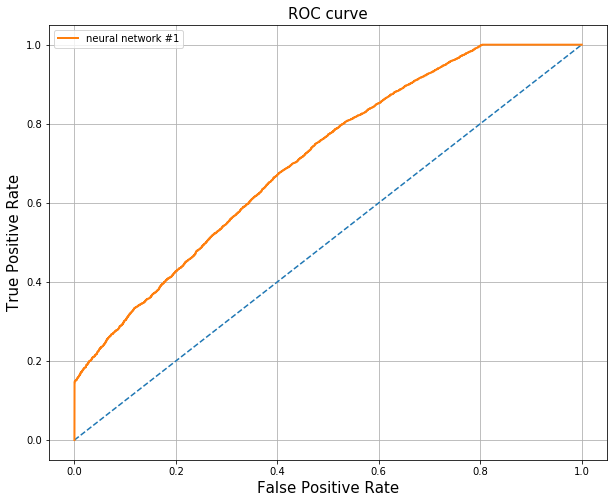

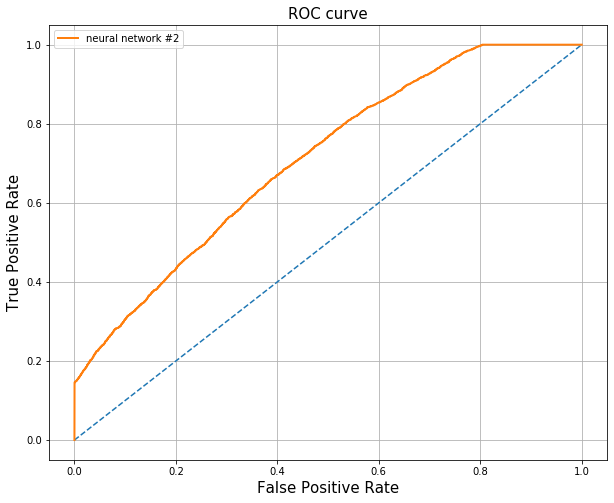

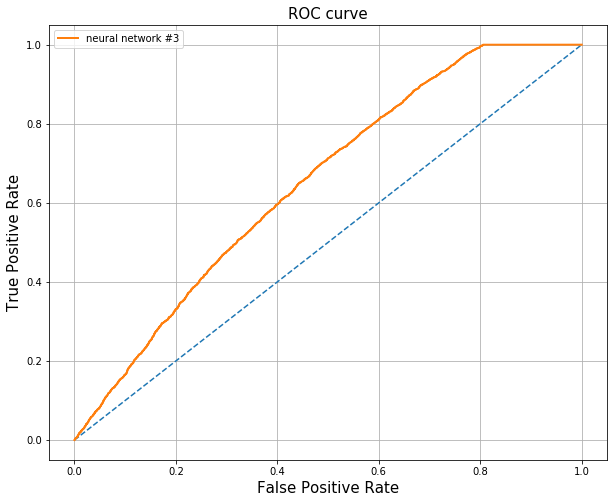

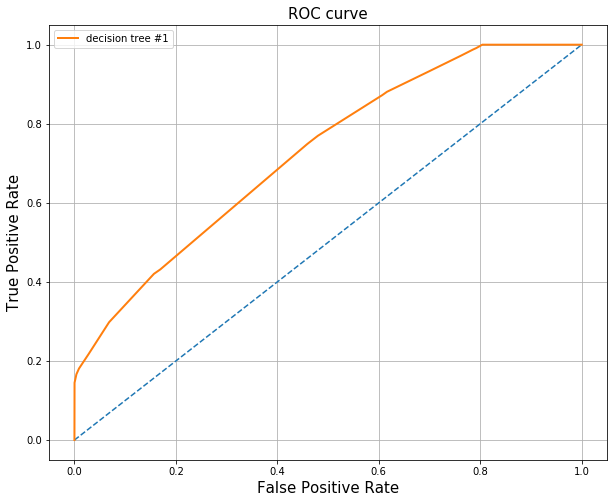

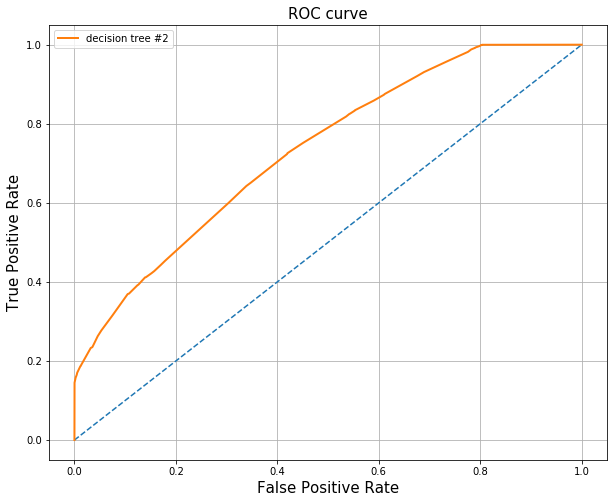

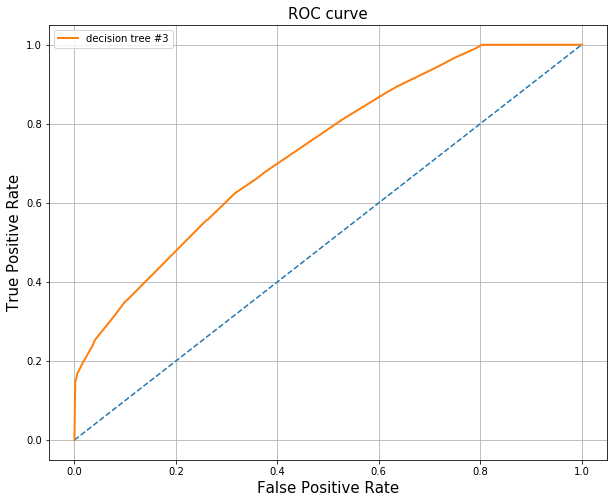

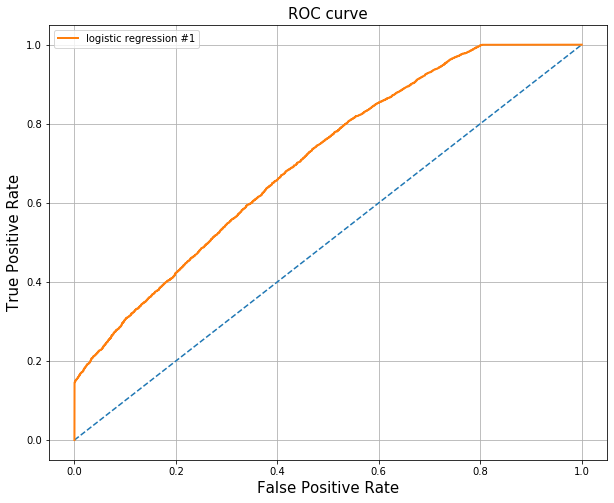

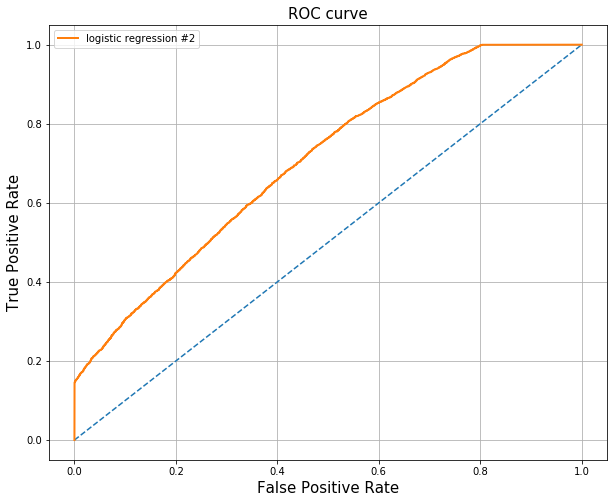

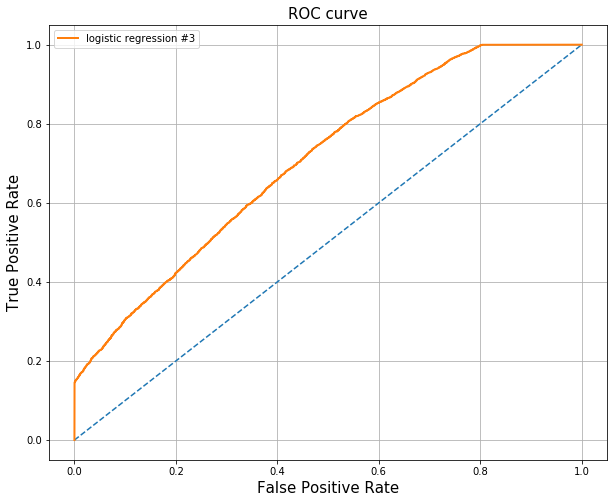

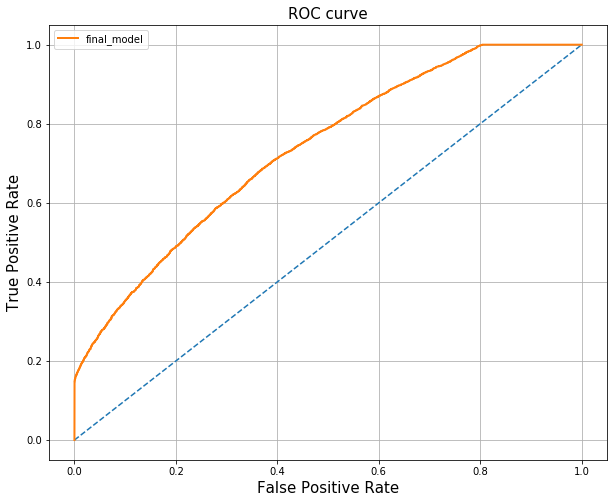

In [129]:
for key, value in estimators_prob.items():
    fpr, tpr, thr = roc_curve(y_true, value)
    create_plot([(fpr, tpr, key)], 'False Positive Rate', 'True Positive Rate', 'ROC curve', 'App/images/{}/ROC_curve {}.png'.format(all_params['name of model with time of create'],key), diag=True)

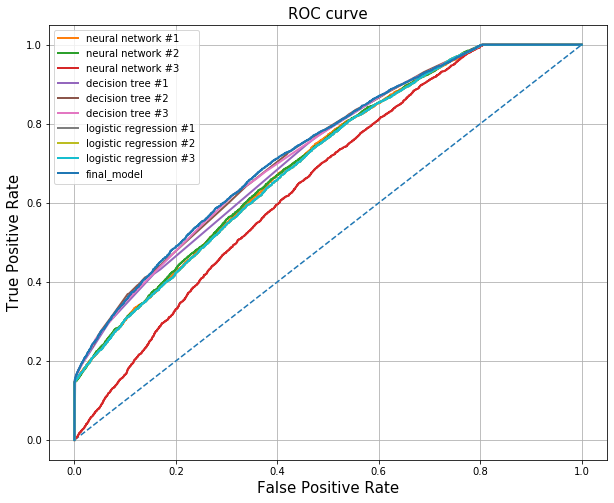

In [130]:
arr = []

for key, value in estimators_prob.items():
    fpr, tpr, thr = roc_curve(y_true, value)
    arr.append((fpr, tpr, key))
    
create_plot(arr, 'False Positive Rate', 'True Positive Rate', 'ROC curve', 'App/images/{}/ROC_curve.png'.format(all_params['name of model with time of create']), diag=True)

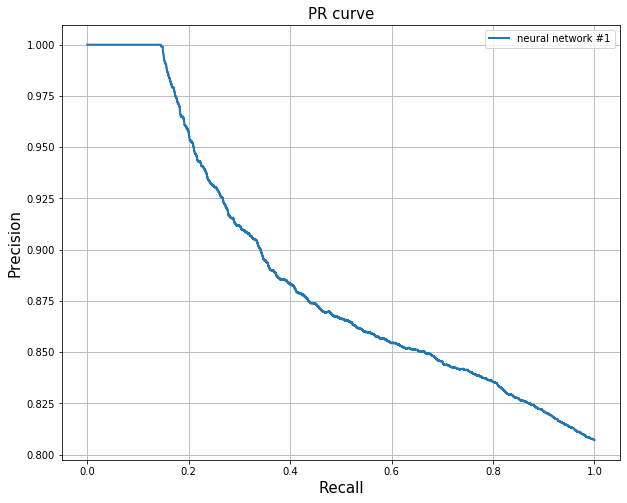

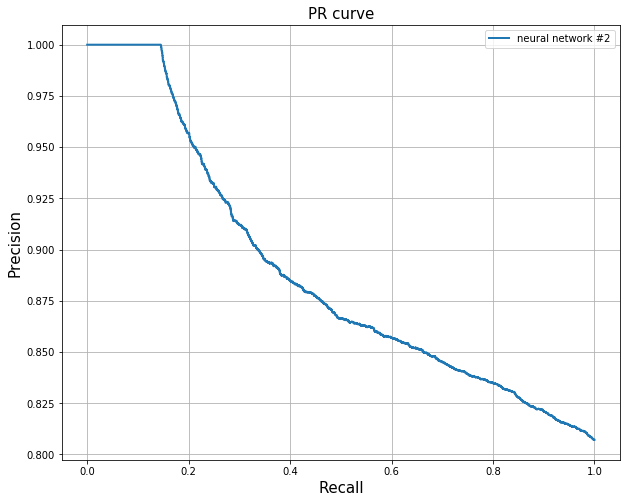

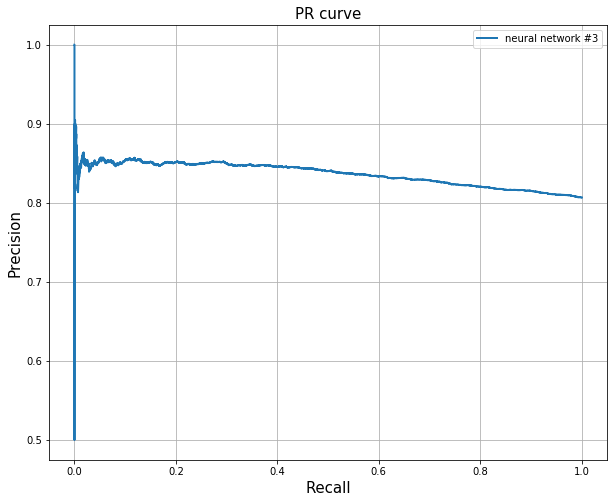

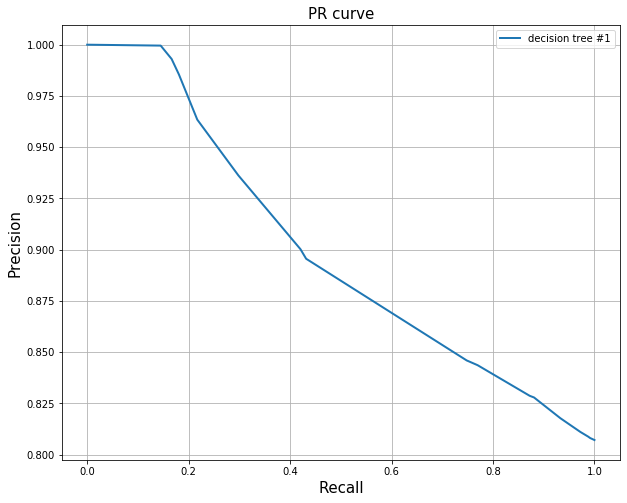

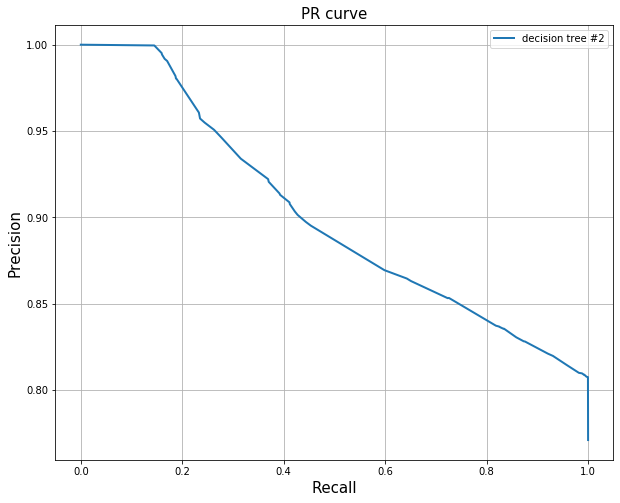

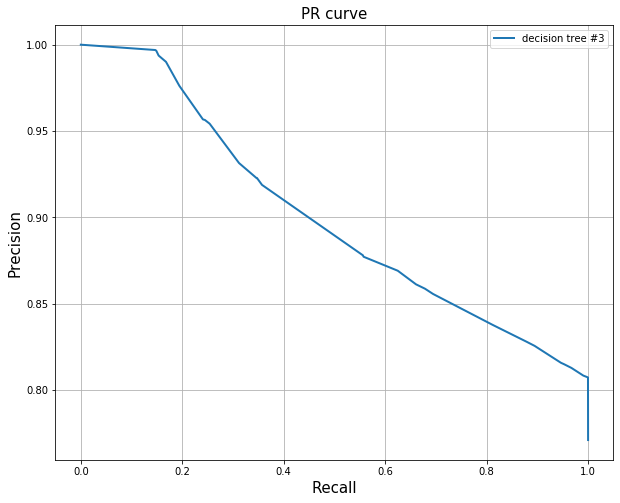

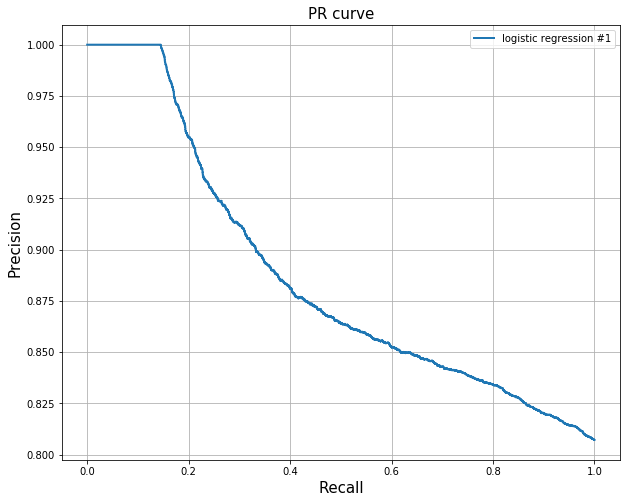

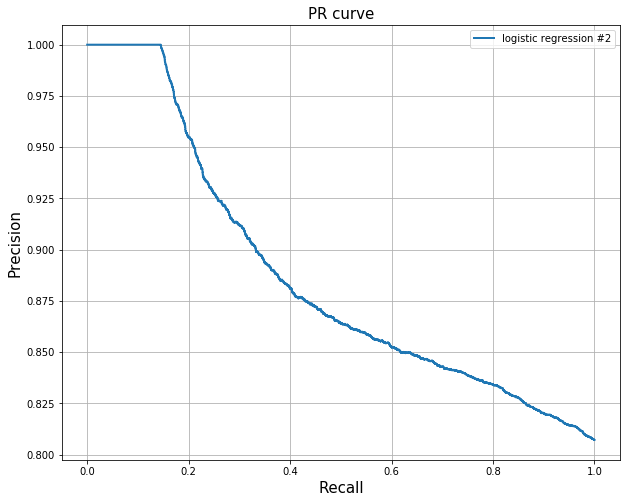

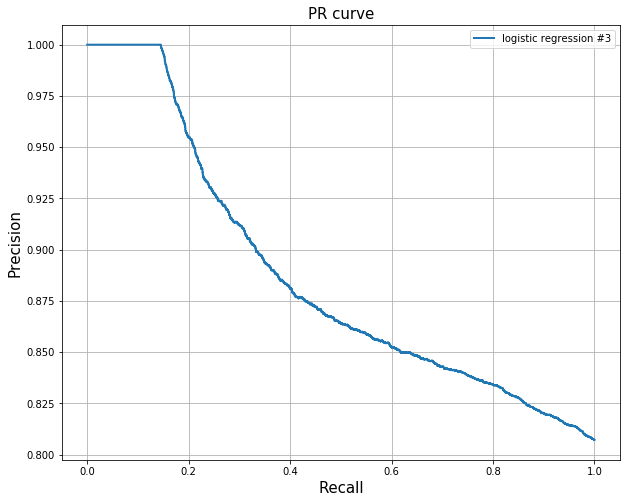

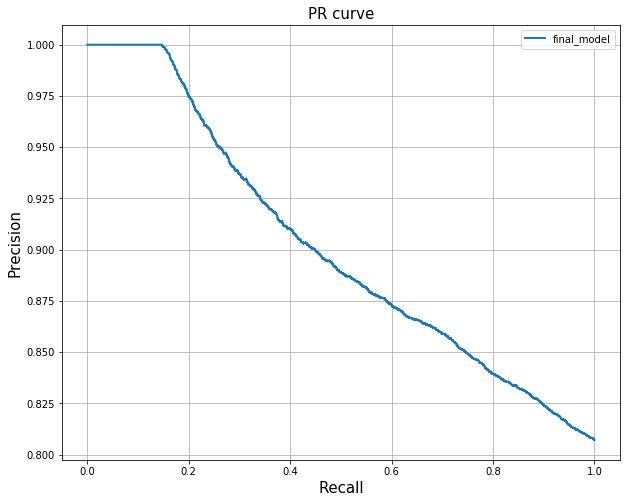

In [131]:
for key, value in estimators_prob.items():
    precision, recall, thr = precision_recall_curve(y_true, value)
    create_plot([(recall, precision, key)], 'Recall', 'Precision', 'PR curve', 'App/images/{}/PR_curve {}.png'.format(all_params['name of model with time of create'],key))

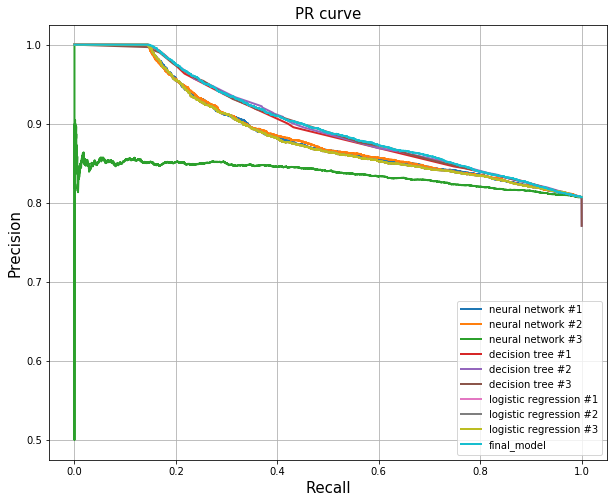

In [132]:
arr = []

for key, value in estimators_prob.items():
    precision, recall, thr = precision_recall_curve(y_true, value)
    arr.append((recall, precision, key))
    
create_plot(arr, 'Recall', 'Precision', 'PR curve', 'App/images/{}/PR_curve.png'.format(all_params['name of model with time of create']))

In [133]:
def create_hist(ones, zeros, name):
    """
    Создание диаграммы (любой)
    """
    plt.figure(figsize=(10,8));
    plt.title(f'Score distribution: {name}', size=15);
    plt.hist(ones, bins=50, alpha=0.5, label='класс 1');
    plt.hist(zeros, bins=50, alpha=0.5, label='класс 0');
    plt.xlabel('Score', size=15);
    plt.ylabel('Число набрюдений', size=15);
    plt.legend();
    plt.savefig('App/images/{}/Distribution_graph {}.png'.format(all_params['name of model with time of create'], name), dpi=200);

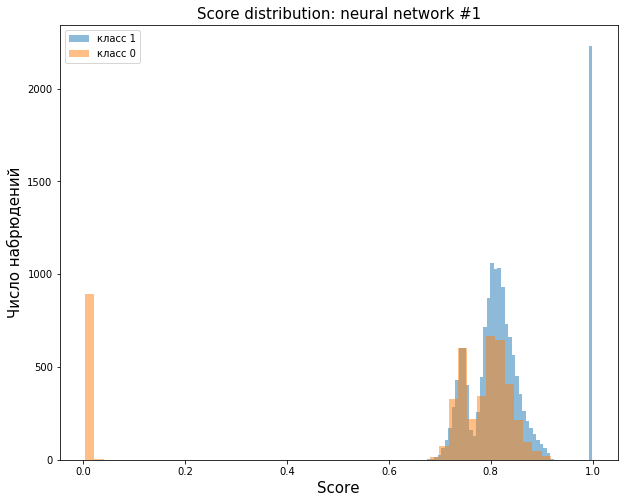

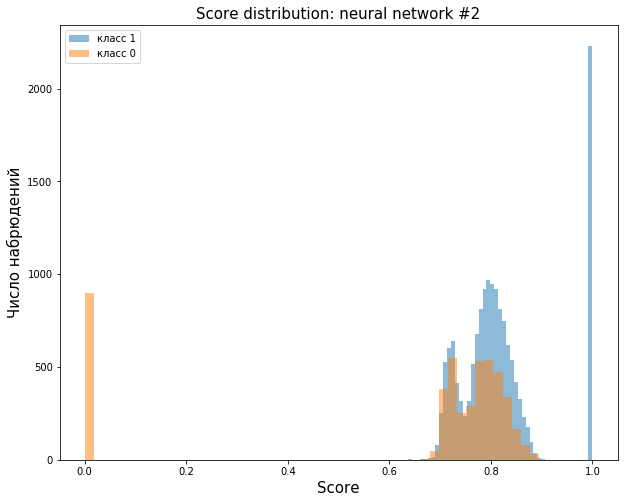

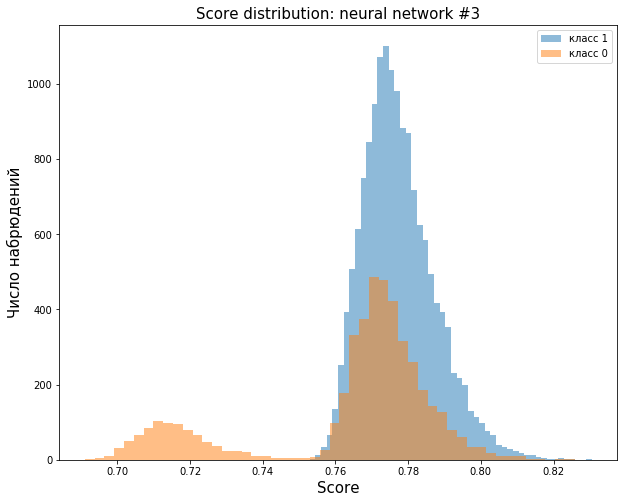

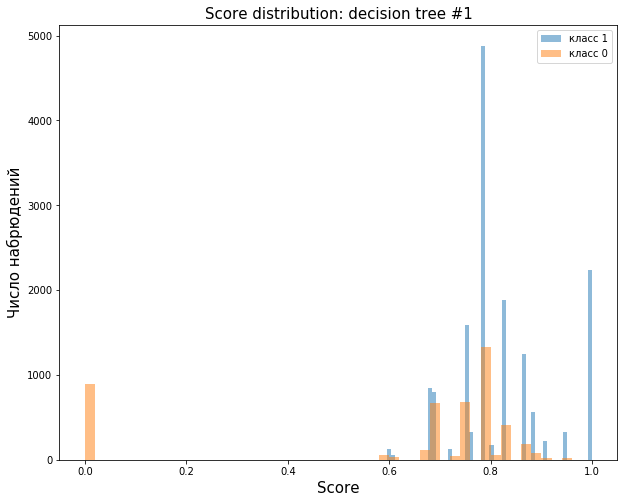

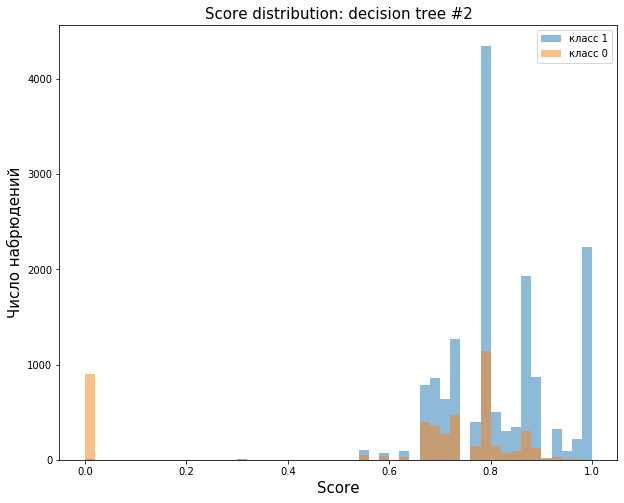

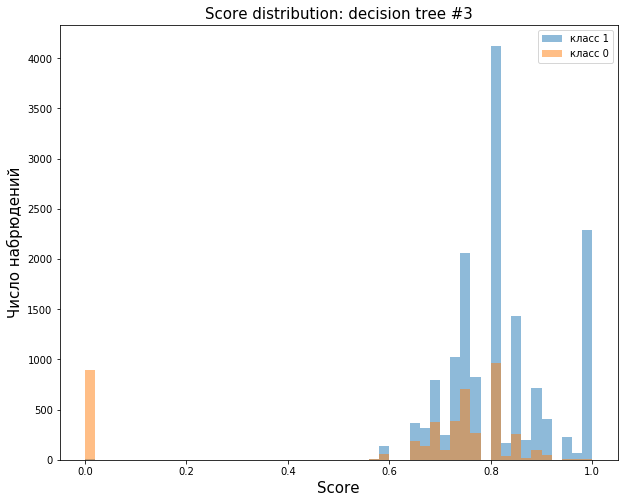

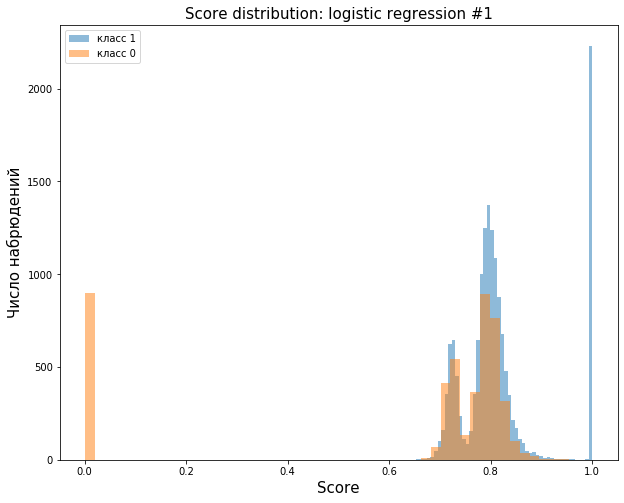

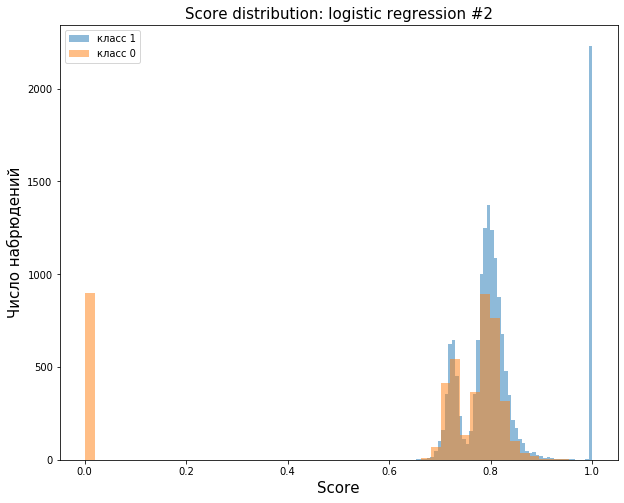

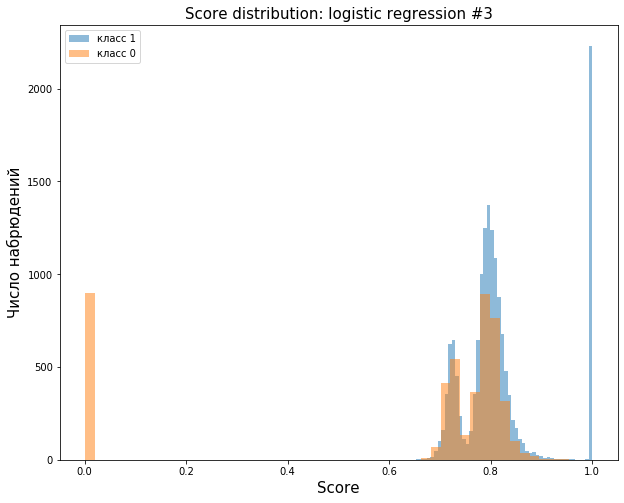

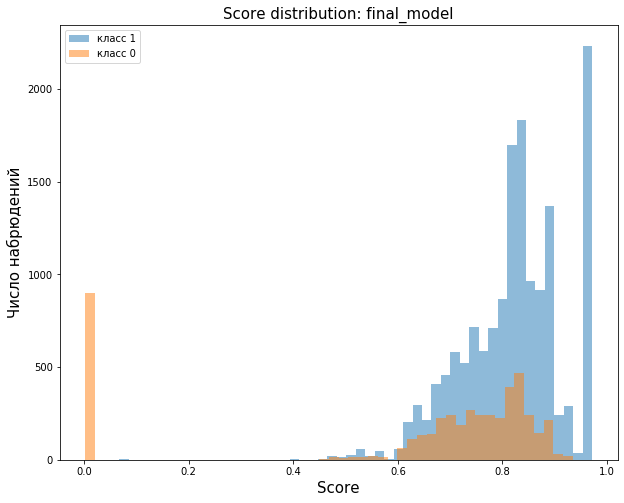

In [134]:
for key, value in estimators_prob.items():
    ones = [x[1] for x in zip(y_true, value) if x[0]==1]
    zeros = [x[1] for x in zip(y_true, value) if x[0]==0]
    create_hist(ones, zeros, key) 

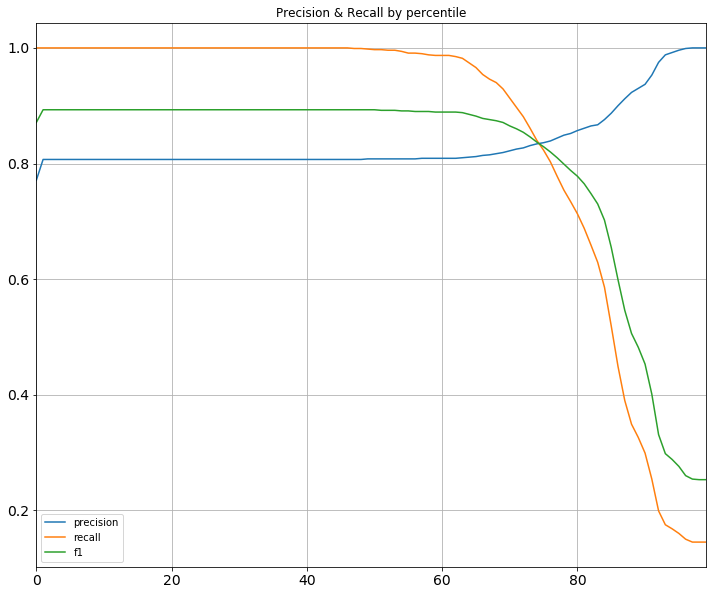

In [135]:
y_prob = estimators_prob['final_model']

pred_min, pred_max = min(y_prob), max(y_prob)
step = (pred_max - pred_min) / 100
step_range = np.arange(pred_min, pred_max, step)
predictions = []

for threshold in step_range:
    preds_binary = np.where(y_prob > threshold, 1, 0)
    prc = round(precision_score(y_true, preds_binary), 3)
    rec = round(recall_score(y_true, preds_binary), 3)
    f1  = round(f1_score(y_true, preds_binary), 3)
    predictions.append([threshold, prc, rec, f1])
    
results = pd.DataFrame(predictions, columns=['threshold', 'precision', 'recall', 'f1'])
ax = results[['precision', 'recall', 'f1']].plot(figsize=(12, 10), 
                                                 grid=True, 
                                                 title='Precision & Recall by percentile',
                                                 fontsize=14);
fig = ax.get_figure()
fig.savefig('App/images/{}/PR_by_prc.png'.format(all_params['name of model with time of create']), dpi=200)

## To docx

In [136]:
def table_to_doc(doc, header, nrows, ncols, matrix):
    """
    Вставка таблицы (с описанием признаков/конфузионной матрицы/кусочка предсказаний) в вордовский документ
    """
    h = doc.add_heading(text=header, level=2)
    if header != '':
        doc.add_paragraph()
    table = doc.add_table(rows=nrows, cols=ncols)
    table.style = 'Table Grid'
    
    for row_num in range(nrows):
        row = table.rows[row_num]
        df_row = matrix[row_num]
        for i, (txt, cell) in enumerate(zip(df_row, row.cells)):
            cell.text = f'{txt}'
            if row_num == 0 or i ==0:
                run = cell.paragraphs[0].runs[0]
                run.font.bold = True

In [137]:
def create_heading(doc, text, level, alignment):
    """
    Добавление заголовка
    """
    h = doc.add_heading(text=text, level=level)
    h.alignment = alignment
    doc.add_paragraph()

In [138]:
def add_graph(doc, img_path, imp_text, width, height):
    """
    Добавление графика
    """
    p = doc.add_paragraph();
    p.alignment = 1
    r = p.add_run();
    r.add_picture(img_path, width=Inches(width), height=Inches(height));
    r.add_text(imp_text);

In [139]:
doc = Document()
width = 6
height = 5

create_heading(doc=doc, text=f'Отчет о результатах обучения модели {pickle_path} по обучающей выборке {train_path}', level=0, alignment=0)
create_heading(doc=doc, text='Характеристики обучающей выборки', level=1, alignment=1)

table_to_doc(doc=doc, header='Описание признаков', nrows=feats_descr.shape[0], ncols=feats_descr.shape[1], matrix=feats_descr)

# Характеристики модели
create_heading(doc=doc, text='Характеристики модели', level=1, alignment=1)

doc.add_paragraph().add_run().add_text(f'Метод отбора признаков: {fs_method}')
doc.add_paragraph().add_run().add_text(f'Метод заполнения пропусков: {fill_null_method}')
doc.add_paragraph().add_run().add_text(f'Метод выявления аномалий: {anomalies_method}')
doc.add_paragraph().add_run().add_text(f'Тип модели: {model_type}')
doc.add_paragraph().add_run().add_text(f'Метод композиции: {composition_method}')
doc.add_paragraph().add_run().add_text(f'Количество базовых моделей: {n_base_models}')
doc.add_paragraph().add_run().add_text(f'Базовые модели:')

img = 1
for i, key in enumerate(all_params['base algorithms'].keys()):
    doc.add_paragraph(f'{key}', style='List Bullet')
    doc.add_paragraph('Параметры:', style='List Bullet 2')
    for k, v in all_params['base algorithms'][key].items():
        doc.add_paragraph(f'{k}: {v}', style='List Bullet 3')
    doc.add_paragraph('Таблица сопряженности', style='List Bullet 2')
    table_to_doc(doc=doc, header='', nrows=4, ncols=4, matrix=confusion_m[key])
    doc.add_paragraph()
    doc.add_paragraph('Результаты классификации', style='List Bullet 2')
    table_to_doc(doc=doc, header='', nrows=6, ncols=5, matrix=clssif_report[key])
    doc.add_paragraph()
    doc.add_paragraph('Roc-кривая', style='List Bullet 2')
    
    if all_params['common params']['composition method'] in ['voting','stacking']: # опять эта херня
        add_graph(doc=doc, img_path='App/images/{}/ROC_curve {}.png'.format(all_params['name of model with time of create'],key), imp_text=f'Рис.{img} Roc-кривая для модели {key}', width=width, height=height)
        img += 1
        doc.add_paragraph()
        doc.add_paragraph('PR-кривая', style='List Bullet 2')
        add_graph(doc=doc, img_path='App/images/{}/PR_curve {}.png'.format(all_params['name of model with time of create'],key), imp_text=f'Рис.{img} PR-кривая для модели {key}', width=width, height=height)
        img += 1
        doc.add_paragraph()
        doc.add_paragraph('Distribution graph', style='List Bullet 2')
        add_graph(doc=doc, img_path='App/images/{}/Distribution_graph {}.png'.format(all_params['name of model with time of create'],key), imp_text=f'Рис.{img} Гистограмма распределения предсказаний модели {key}', width=width, height=height)
        img += 1
        doc.add_paragraph()
        
    else:
        pass
        
        
        
# Характеристики прогноза по итоговой модели
if all_params['common params']['composition method'] in ['voting','stacking']:
    create_heading(doc, text='Характеристики прогноза по итоговой модели', level=1, alignment=1)
    table_to_doc(doc=doc, header='Таблица сопряженности', nrows=4, ncols=4, matrix=confusion_m['final_model'])
    table_to_doc(doc=doc, header='Результаты классификации', nrows=6, ncols=5, matrix=clssif_report['final_model'])

# Визуализация результатов
doc.add_paragraph();
create_heading(doc, text='Визуализация результатов', level=2, alignment=0)

add_graph(doc=doc, img_path='App/images/{}/ROC_curve.png'.format(all_params['name of model with time of create']), imp_text=f'Рис.{img} Roc-кривая', width=width, height=height)
img += 1
add_graph(doc=doc, img_path='App/images/{}/PR_curve.png'.format(all_params['name of model with time of create']), imp_text=f'Рис.{img} PR-кривая', width=width, height=height)
img += 1
add_graph(doc=doc, img_path='App/images/{}/PR_by_prc.png'.format(all_params['name of model with time of create']), imp_text=f'Рис.{img} График precision и recall по перцентилям', width=width, height=height)
img += 1
add_graph(doc=doc, img_path='App/images/{}/Distribution_graph final_model.png'.format(all_params['name of model with time of create']), imp_text=f'Рис.{img} Гистограмма распределения предсказаний итоговой модели', width=width, height=height)

test_ex = np.vstack((pred_test.columns, pred_test.head(10).values))
table_to_doc(doc=doc, header='Предсказание на тестовой выборке', nrows=11, ncols=3, matrix=test_ex)

In [140]:
path_to_final_word = 'Output/{}/fin.docx'.format(all_params['name of model with time of create'])
doc.save(path_to_final_word)

# Итого, попробуем перечислить основные проблемы по классификатору:

- **!!!Ранее писался в .ipynb, потом спешно переписывался на .py, поэтому потерял удобство чтения, надо рефакторить!!!**
- Можно обсудить введение признака модели по умолчанию
- Добавить метрики по трейну в отчет
- Сделать вариант нормализации как общий параметр и убрать багу в отчете
- Сделать работу с категориальными признаками
- Договорться по поводу *if type == .. elif type== ... elif type==...*
- Посмотреть подбор параметров по сетке (сложно)
- !!!ОБСУДИТЬ РАЗНЫЕ ТИПЫ КОМПОЗИЦИЙ (ТРЕБУЮТ ОДИН БАЗОВЫЙ ТИП / МОГУТ РАБОТАТЬ С НЕСКОЛЬКИМИ) И ВЫТЕКАЮЩИЕ ПОСЛЕДСТВИЯ (В Т.Ч. ОБРАСТАНИЕ КОДА КОСТЫЛЯМИ)
- !!!ПРОТЕСТИРОВАТЬ АДЕКВАТНОСТЬ РАБОТЫ КЛАССИФИКАТОРЫ НА ДАТАСЕТАХ ПОМЕНЬШЕ!!!

Еще немного хотелок от ДВ
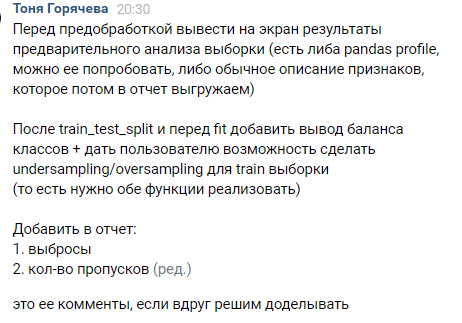

По веб-интерфейсу тоже есть пути улучшения, но это лучше дополнительно спросить у Макса